# QSVM (Qiskit) — Quantum Kernel SVM
This notebook replaces the PennyLane quantum kernel SVM with a **Qiskit Machine Learning** quantum-kernel workflow that can run on **IBM Quantum Platform**.

**Outputs you asked for:** the **feature map circuit** and an explicit **kernel overlap circuit** (for any pair of datapoints).

In [1]:
# If running locally, install dependencies (comment out if already installed)
%pip -q install "qiskit>=1.0" "qiskit-machine-learning>=0.8" "qiskit-ibm-runtime>=0.20" scikit-learn matplotlib numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## 1) Dataset + classical baseline

Classical SVM accuracy: 0.9866666666666667


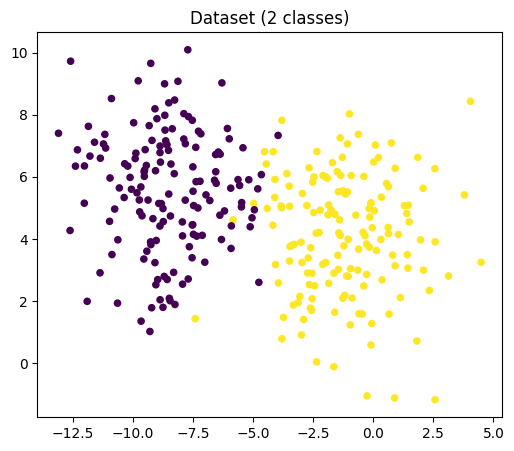

In [3]:
# Generate a simple 2D dataset (same idea as your original notebook)
X, y = make_blobs(n_samples=300, centers=2, random_state=7, cluster_std=2.0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7, stratify=y)

# Classical baseline SVM
clf = SVC(kernel="rbf", gamma="scale")
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print("Classical SVM accuracy:", accuracy_score(y_test, preds))

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20)
plt.title("Dataset (2 classes)")
plt.show()

## 2) Quantum kernel (Qiskit)

In [4]:
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityStatevectorKernel

In [5]:
# IMPORTANT: Feature-map inputs should be in a reasonable range (commonly [0, π]).
scaler = MinMaxScaler(feature_range=(0.0, np.pi))
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Feature map circuit (this is what actually gets run on hardware)
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

print("Feature map circuit:")
print(feature_map.draw(output="text"))

Feature map circuit:
     ┌──────────────────────────┐
q_0: ┤0                         ├
     │  ZZFeatureMap(x[0],x[1]) │
q_1: ┤1                         ├
     └──────────────────────────┘


C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_6036\2210597249.py:7: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=2, reps=2)


### Explicit kernel-overlap circuit U(x) · U(y)†

In [6]:
def kernel_overlap_circuit(x: np.ndarray, y: np.ndarray, fm: QuantumCircuit) -> QuantumCircuit:
    """Build the overlap-test circuit used by fidelity-based kernels:
    prepare |0>, apply U(x), then U(y)†, then measure all qubits.
    The kernel value is Pr(measure all-zeros).
    """
    # bind parameters by position: fm has parameters in order
    fm_x = fm.assign_parameters({p: float(v) for p, v in zip(fm.parameters, x)})
    fm_y = fm.assign_parameters({p: float(v) for p, v in zip(fm.parameters, y)})
    qc = QuantumCircuit(fm.num_qubits, fm.num_qubits)
    qc.compose(fm_x, inplace=True)
    qc.compose(fm_y.inverse(), inplace=True)
    qc.measure(range(fm.num_qubits), range(fm.num_qubits))
    return qc

# Show an example overlap circuit for the first train pair
example_qc = kernel_overlap_circuit(X_train_s[0], X_train_s[1], feature_map)
print(example_qc.draw(output="text"))

     ┌──────────────────────────────┐┌─────────────────────────────────┐┌─┐   
q_0: ┤0                             ├┤0                                ├┤M├───
     │  ZZFeatureMap(2.3245,1.6976) ││  ZZFeatureMap_dg(1.5528,2.2265) │└╥┘┌─┐
q_1: ┤1                             ├┤1                                ├─╫─┤M├
     └──────────────────────────────┘└─────────────────────────────────┘ ║ └╥┘
c: 2/════════════════════════════════════════════════════════════════════╩══╩═
                                                                         0  1 


### Train an SVM using the quantum kernel

In [7]:
qkernel = FidelityStatevectorKernel(feature_map=feature_map)

# Use scikit-learn SVC with a callable kernel matrix
# (SVC expects a function K(X1, X2) -> Gram matrix)
def qkernel_callable(X1, X2):
    return qkernel.evaluate(X1, X2)

qsvc = SVC(kernel=qkernel_callable)
qsvc.fit(X_train_s, y_train)

q_preds = qsvc.predict(X_test_s)
print("Quantum kernel SVM accuracy:", accuracy_score(y_test, q_preds))

Quantum kernel SVM accuracy: 0.8


## 3) Run on IBM Quantum Platform (optional)
If you have IBM Quantum credentials set up, you can swap in the Runtime Sampler.

In [8]:
# --- IBM Quantum Platform (Runtime) ---
# Follow IBM instructions to save your account (one-time):
#   from qiskit_ibm_runtime import QiskitRuntimeService
#   QiskitRuntimeService.save_account(channel="ibm_quantum", token="YOUR_IBM_TOKEN", overwrite=True)

# Then:
# from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
#
# with Session(service=service, backend=backend) as session:
#     sampler_ibm = SamplerV2(session=session)
#     qkernel_ibm = FidelityQuantumKernel(feature_map=feature_map, sampler=sampler_ibm)
#     def qkernel_callable_ibm(X1, X2):
#         return qkernel_ibm.evaluate(X1, X2)
#     qsvc_ibm = SVC(kernel=qkernel_callable_ibm)
#     qsvc_ibm.fit(X_train_s, y_train)
#     q_preds_ibm = qsvc_ibm.predict(X_test_s)
#     print("IBM Quantum QSVM accuracy:", accuracy_score(y_test, q_preds_ibm))

print("Optional IBM Runtime cell ready.")

Optional IBM Runtime cell ready.
